# Encoded Value-at-Risk

In this notebook, we are going to calculate Value-at-Risk (VaR) for a portfolio of stocks listed on Tehran Stock Exchange (TSE) using Encoded VaR technique proposed by Ehsan Tabatabaei with supervision of Dr. Hamidreza Arian in a Master's thesis at Khatam University.

**Table of Contents:**

* [1.Data Preprocessing](#section1)
    * [1.1 Splitting the Data](#section3)
    * [1.2 Data Normalization](#section2)
* [2.Model Definition](#section4)
    * [2.1 Encoder Network](#section5)
    * [2.2 Decoder Network](#section6)
    * [2.3 Loss Function](#section7)
* [3 Training the Model](#section8)
* [4 Testing the Model](#section9)
    * [4.1 Loss Graph](#section10)
* [5.Calculating Encoded VaR](#section11)
    * [5.1 Scale and Volatility Forecast](#section12)
    * [5.2 Encoding the Shape of uncertainty](#section14)
    * [5.3 Imposing the Mean and the STD](#section15)
* [6.Calculating VaR and CVaR of Benchmark Models](#section16)
    * [6.1 Historical Simulation](#section24)
    * [6.3 Monte Carlo Simulation](#section38)
* [7.Backtesting the Resulted Values](#section17)
    * [7.1 Backtesting Encoded VaR](#section18)
        * [7.1.1 Actual Returns vs Forecsted VaR Plot](#section19)
        * [7.1.2 Statistival Tests of Christoffersson's Method](#section20)
        * [7.1.3 Lopez Loss Function](#section50)
    * [7.2 Backtesting Historical Simulation](#section25)
        * [7.2.1 Actual Returns vs Forecsted VaR Plot](#section26)
        * [7.2.2 Statistival Tests of Christoffersson's Method](#section27)
        * [7.2.3 Lopez Loss Function](#section70)
    * [7.3 Backtesting Monte Carlo Simulation](#section39)
        * [7.3.1 Actual Returns vs Forecsted VaR Plot](#section40)
        * [7.3.2 Statistival Tests of Christoffersson's Method](#section41)
        * [7.3.3 Lopez Loss Function](#section60)
* [8.Sum Up](#section45)

In [1]:
## Importing necessary modules:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import seaborn as sns;sns.set_style("whitegrid")
from keras.layers import Dense, Lambda, LeakyReLU
import keras.backend as K
from keras.models import Model, Input
from keras.regularizers import l1_l2
from keras.optimizers import adam
from keras.losses import mse
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from IPython.core.display import SVG
from arch.univariate import GARCH, ARX
from arch import arch_model
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from BackTest import Backtest
from scipy import stats
from datetime import datetime, timedelta
from random import sample
import time

Using TensorFlow backend.


In [2]:
def parse(datestr):
    return datetime.strptime(datestr, '%m/%d/%Y')

In [6]:
## Importing input returns:
rets = pd.read_csv("returns2.csv", header=0, index_col=0, encoding="utf-8", date_parser=parse, parse_dates=[0])
rets.head()

,همراه,شفارس,سخاش,پلوله,شبهرن,والبر,خفنر,شپترو,ملت,ثاخت,...,حکشتی,واعتبار,وپارس,دعبید,حفاری,شدوص,چنوپا,ثفارس,دتهران,فایرا
date,,,,,,,,,,,,,,,,,,,,,
2010-03-28,0.0,0.0,0.000000,0.0,0.0,-0.008699,0.000743,0.012985,0.0,0.000000,...,-0.014887,0.0,0.021178,0.017083,0.018526,0.000000,0.0,0.000000,0.0,0.0
2010-03-29,0.0,0.0,0.000000,0.0,0.0,0.019798,0.000000,0.000518,0.0,0.000000,...,0.009956,0.0,0.002775,0.000000,-0.001834,0.000000,0.0,0.000000,0.0,0.0
2010-03-30,0.0,0.0,0.000000,0.0,0.0,-0.013194,0.008831,-0.000251,0.0,0.000000,...,0.005426,0.0,-0.009917,0.000000,0.003665,-0.035684,0.0,0.000000,0.0,0.0
2010-03-31,0.0,0.0,0.000000,0.0,0.0,0.018011,0.000000,0.000000,0.0,0.000000,...,-0.015382,0.0,0.007536,0.001129,-0.002937,0.000000,0.0,0.000000,0.0,0.0
2010-04-03,0.0,0.0,0.009486,0.0,0.0,0.008885,0.033877,0.040470,0.0,0.000468,...,0.043061,0.0,0.029990,0.000000,0.043161,0.000000,0.0,0.003056,0.0,0.0


In [7]:
rets.isnull().any().any()

False

<a id='section1'></a>
# 1.Data Preprocessing

<a id='section3'></a>
## 1.1 Splitting the data:

When the model is trained, we need to see if it's working as expected or not. To do so, before training the model we keep a bunch of the data as our test set to use it afterwards. Edditionally, while training the model we should know how accurate or false is the model going to be. So, we keep another set called validation set to use it then.

In [8]:
## Split the data:
raw_data = rets
train_pct, valid_pct = 0.7, 0.15
n = raw_data.shape[0]
n_train = np.floor(n * train_pct)
n_valid = np.floor(n * (train_pct + valid_pct))
train_set = raw_data.values[:int(n_train), :]
valid_set = raw_data.values[int(n_train):int(n_valid), :]
test_set = raw_data.values[int(n_valid):, :]
train_idx = rets.index[:int(n_train)]
valid_idx = rets.index[int(n_train):int(n_valid)]
test_idx = rets.index[int(n_valid):]
print(train_set.shape)
print(valid_set.shape)
print(test_set.shape)

(3195, 331)
(685, 331)
(685, 331)


<a id='section2'></a>
## 1.2 Data Normalization

Due to the fact that neural networks can't handle data scales, when working with these models we consider re-scaling the data between 0 and 1 so that all our data would be the same for the model. Here, we use MinMaxScale to do so.

In [9]:
Max = np.max(train_set, axis=0)
Min = np.min(train_set, axis=0)
train_set = (train_set - Min) / (Max - Min)
test_set = (test_set - Min) / (Max - Min)
valid_set = (valid_set - Min) / (Max - Min)

In [10]:
## Hyperparameters:
cols = rets.columns
original_dim = raw_data.shape[1]
input_shape = (original_dim,)
intermediate_dim = 200
# intermediate_dim2 = 100
# intermediate_dim3 = 25
batch_size = 64
latent_dim = 5
encoder_layer1_l1=encoder_layer1_l2=decoder_layer1_l1=decoder_layer1_l2=decoder_layer2_l1=decoder_layer2_l2=decoder_layer3_l1=decoder_layer3_l2=0.0
alpha = 5
weights = np.ones((original_dim, 1)) / original_dim  ## equally weighted
error = 0.05
i = 10

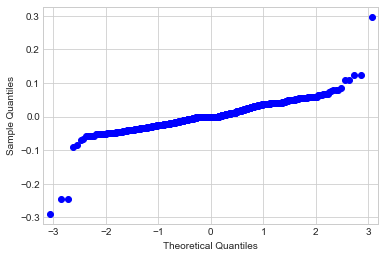

In [8]:
## kernel plot
qqplot(rets.iloc[:,i].sample(frac=0.2, replace=True, random_state=0))
plt.show()
# plt.savefig("C:\\Users\\ehsan\\Desktop\\qqplot.svg")

In [9]:
stats.jarque_bera(rets.iloc[:,i])

(20034.236807525464, 0.0)

In [10]:
stats.kurtosis(rets.iloc[:,i])

10.26177088563184

In [11]:
pd.DataFrame(rets.iloc[:,i]).describe(include='all')

,ثنوسا
count,4565.000000
mean,0.001100
std,0.030490
min,-0.291169
25%,-0.018638
50%,0.000000
75%,0.020208
max,0.297015


<a id='section4'></a>
# 2.Model Definition

__The Architecture of the Model__

The model consisted of two networks: the encoder and the decoder.
We aim to reduce the dimension of the data in the encoder, and to increase it in the decoder.
The input and the output of the model are the same. You can see the diagram of VAE model we use in the chart below:

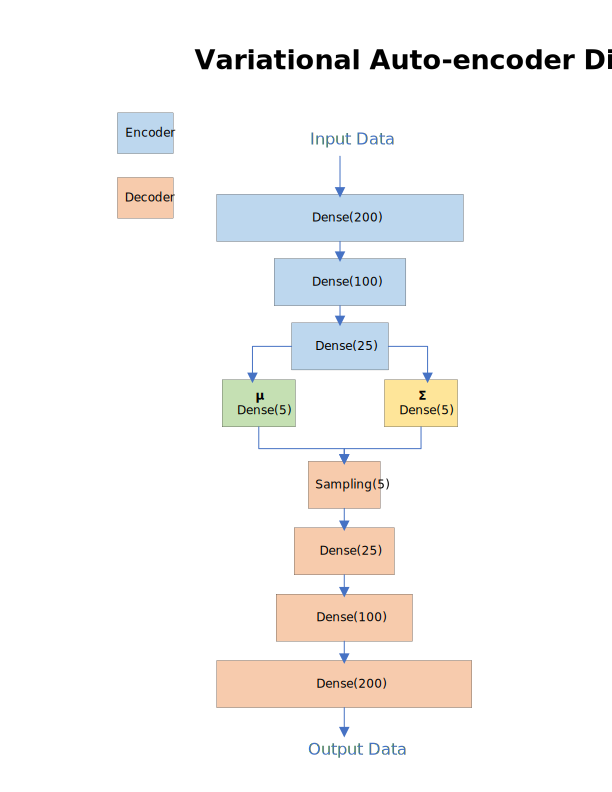

In [33]:
SVG("VAE Diagram2.svg")

<a id='section5'></a>
## 2.1 Encoder Network

The encoder network in an auto-encoder model is used to decrease the dimension of the input data. But in a variational auto-encoder model, the encoder network also outputs the mean and the log of standard deviation for the latent space.

In [11]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim, activation='sigmoid', name='intermediate_1', kernel_regularizer=l1_l2(l1=encoder_layer1_l1, l2=encoder_layer1_l2))(inputs)
# x2 = Dense(intermediate_dim2, activation='sigmoid', name='intermediate_2')(x1)
# x3 = Dense(intermediate_dim3, activation='sigmoid', name='intermediate_3')(x1)
z_mean = Dense(latent_dim, name='z_mean')(x1)
z_log_var = Dense(latent_dim, name='z_log_var')(x1)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 331)          0                                            
__________________________________________________________________________________________________
intermediate_1 (Dense)          (None, 200)          66400       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            1005        intermediate_1[0][0]             
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 5)            1005        intermediate_1[0][0]             
__________________________________________________________________________________________________
z (Lambda)

<a id='section6'></a>
## 2.2 Decoder Network

After reducing the dimension of the input data using the encoder network, we use the decoder network to increase the dimension up to the original dimension of the input data. In the decoder networks of variational auto-encoders, we first generate random numbers, in normal distribution space, using the means and the standard deviations resulted from the encoder network. Then we try to re-create the input data from the random sample, and this is why the output of this model is generative.

In [12]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x1 = Dense(intermediate_dim3, kernel_regularizer=l1_l2(l1=decoder_layer1_l1, l2=decoder_layer1_l2))(latent_inputs)
# x1_act = LeakyReLU()(x1)
# x2 = Dense(intermediate_dim2, kernel_regularizer=l1_l2(l1=decoder_layer2_l1, l2=decoder_layer2_l2))(x1_act)
# x2_act = LeakyReLU()(x2)
x3 = Dense(intermediate_dim, kernel_regularizer=l1_l2(l1=decoder_layer3_l1, l2=decoder_layer3_l2))(latent_inputs)
x3_act = LeakyReLU()(x3)
outputs = Dense(original_dim, activation='sigmoid')(x3_act)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1200      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 331)               66531     
Total params: 67,731
Trainable params: 67,731
Non-trainable params: 0
_________________________________________________________________


In [13]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

<a id='section7'></a>
## 2.3 Loss Function

Our loss function is defined as the sum of KL divergence term and reconstruction error term. The KL divergence computes the differece in terms of distribution shape, for the real distribution and the desired distribution of the latent space. The reconstruction error is computed as the mean square error of generated vs real values. The loss for the model is calculated as follows:

$
    \begin{equation}\label{eq:lower bound}
        \begin{aligned}
            \mathcal{L}(q) &= \sum q(z)\log{\frac{p(X,Z)}{q(Z)}} \\
            &= \sum{q(Z)\log{p(X|Z)}} + \sum{q(Z)\log{\frac{p(Z)}{q(Z)}}} \\
            &= E_{q(Z)}p(X|Z) - D_{KL}\big(q(Z) || p(Z)\big) \\
            &= -E|X-\bar{X}| - \frac{1}{2}\sum{\big(1 + \log{\sigma^{2}} - \mu^{2} \sigma^{2}\big)}\\
        \end{aligned}
    \end{equation}
$

In [14]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss * 2 + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 331)               0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 68410     
_________________________________________________________________
decoder (Model)              (None, 331)               67731     
Total params: 136,141
Trainable params: 136,141
Non-trainable params: 0
_________________________________________________________________


<a id='section8'></a>
# 3.Training the model

VAE model is trained as a whole and after learning the weights, we can use either the encoder and the decoder separately. Here, we use adam optimizer and accuracy metric to compile the model.

Then, we run backpropagation technique to train the model for 100 epochs. Also we used [adaptive learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) and [early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) to avoid [overfitting](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/).

In [15]:
Adam = adam(0.01)
vae.compile(optimizer=Adam)

In [16]:
t0 = time.time()
epochs = 100
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.0001, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=14, verbose=1, mode='auto')
# checkpointer = ModelCheckpoint(filepath="best_vae_model.hdf5", verbose=0, save_best_only=True)
history = vae.fit(train_set, epochs=epochs, batch_size=batch_size, validation_data=(valid_set, None), callbacks=[reduceLR,earlystopping])
t1 = time.time()

Train on 3195 samples, validate on 685 samples
Epoch 1/100
3195/3195 [==============================] - 1s 177us/step - loss: 606.7857 - val_loss: 354.4674
Epoch 2/100
3195/3195 [==============================] - 0s 59us/step - loss: 303.1855 - val_loss: 351.8469
Epoch 3/100
3195/3195 [==============================] - 0s 70us/step - loss: 301.4303 - val_loss: 349.3921
Epoch 4/100
3195/3195 [==============================] - 0s 63us/step - loss: 298.8551 - val_loss: 346.3529
Epoch 5/100
3195/3195 [==============================] - 0s 58us/step - loss: 297.6296 - val_loss: 346.7830
Epoch 6/100
3195/3195 [==============================] - 0s 59us/step - loss: 295.9477 - val_loss: 346.2038
Epoch 7/100
3195/3195 [==============================] - 0s 65us/step - loss: 296.1294 - val_loss: 345.4124
Epoch 8/100
3195/3195 [==============================] - 0s 63us/step - loss: 294.8410 - val_loss: 343.2283
Epoch 9/100
3195/3195 [==============================] - 0s 59us/step - loss: 294.6817 -

In [17]:
print(t1 - t0)

6.24544095993042


<a id='section9'></a>
# 4.Testing the Model

After Training the model, we should test the model to see if the model has trained properly or not. This is done through some visualizations.

<a id='section10'></a>
## 4.1 Loss Graph

Loss graph shows how the learning process has decreased model's loss. This graph helps checking the functionality of the learning process.

number of epochs: 25 


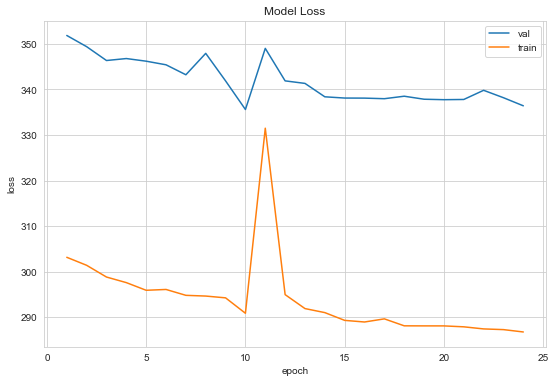

In [18]:
x = [x for x in range(len(history.history['val_loss']))]
start = 1
print('number of epochs: %s ' %len(history.history['val_loss']))
plt.figure(figsize=(9,6))
plt.plot(x[start:] ,history.history['val_loss'][start:],x[start:] , history.history['loss'][start:])
plt.title('Model Loss')
plt.legend(['val','train'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
# plt.savefig("C:\\Users\\ehsan\\Desktop\\train.svg")

<a id='section11'></a>
# 5.Calculating Encoded VaR

After having the model trained and tested, it is the time to use the model to forecast what we wanted to, value-at-risk.

To do so, first we need to forecast the mean and the standard deviation. Then, we will get the shape of the distribution of the portfolio's returns from the variational AE model. Finally, we impose the means and the deviations on the forecasted distributions and calculate the forecasted VaR using quantiles.

<a id='section12'></a>
## 5.1 Scale and Volatility Forecast

Due to the fact that neural network models are unable to understand scales, they just give us the shape of the generative distribution and we should set the mean and the standard deviation manually.

In this project, we use ARIMA(1,1,1) and GARCH(1,1) to estimate future values for the mean and the standard deviation, respectively. In the following cell, we are going to estimate these values for the test set, which is our forecasting window.

In [19]:
train_set2 = rets.values[:int(n_train), :]
valid_set2 = rets.values[int(n_train):int(n_valid), :]
test_set2 = rets.values[int(n_valid):, :]
train_set2 = np.dot(train_set2, weights)
valid_set2 = np.dot(valid_set2, weights)
test_set2 = np.dot(test_set2, weights)
print(train_set2.shape)
print(valid_set2.shape)
print(test_set2.shape)

(3195, 1)
(685, 1)
(685, 1)


In [20]:
window_length = train_set2.shape[0] + valid_set2.shape[0]
fit_set = rets.dot(weights)
fit_set = fit_set * 100.0 # in terms of percentages

In [21]:
fit_set.iloc[:window_length].describe()

,0
count,3880.000000
mean,0.113167
std,0.730490
min,-3.760805
25%,-0.268839
50%,0.091013
75%,0.458609
max,3.912559


In [22]:
window = fit_set.values[:-test_set2.shape[0]]

In [23]:
## Stationarity test:
result = adfuller(fit_set.values[:,0])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.405642
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [ ]:
# ARIMA:

def define_arima(order):
    arima = ARIMA(window, order=order)
    arima_fit = arima.fit(disp=0)
    return (arima_fit.aic, arima_fit.bic)

grid = [(p,0,q) for p in [1,2,3] for q in [1,2,3]]
criterion = {x:None for x in grid}
for g in grid:
    criterion[g] = define_arima(g)
print(min(criterion.items(), key = lambda x: x[1][1]),'best on bic')
print(min(criterion.items(), key = lambda x: x[1][1]),'best on aic')
best_order = min(criterion.items(), key = lambda x: x[1][1])[0]

In [ ]:
criterion

In [87]:
## Arch test:
ar = ARX(window)
res = ar.fit(disp='off').resid
result = het_arch(res)
print(result[0],'Lagrange multiplier test statistic')
print('p-value: %f' % result[1])

976.3883673348195 Lagrange multiplier test statistic
p-value: 0.000000


In [66]:
garch = arch_model(window, mean='AR', dist='normal', vol='garch', p=1, q=1, o=1)
garch_fit = garch.fit(disp="off")
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         AR - GJR-GARCH Model Results                         
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.005
Mean Model:                        AR   Adj. R-squared:                 -0.005
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3751.48
Distribution:                  Normal   AIC:                           7512.95
Method:            Maximum Likelihood   BIC:                           7544.27
                                        No. Observations:                 3880
Date:                Fri, Sep 20 2019   Df Residuals:                     3875
Time:                        00:38:14   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const          0.0640  9.943e-03      6.439  1.202e-10 [4.453e-02,8.351e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0195  7.760e-03      2.513  1.198e-02  [4.290e-03,3.471e-02]
alpha[1]       0.1630  3.479e-02      4.686  2.785e-06    [9.485e-02,  0.231]
gamma[1]   4.2719e-03  1.750e-02      0.244      0.807 [-3.003e-02,3.857e-02]
beta[1]        0.8038  4.354e-02     18.461  4.220e-76      [  0.718,  0.889]
=============================================================================

Covariance estimator: robust
"""

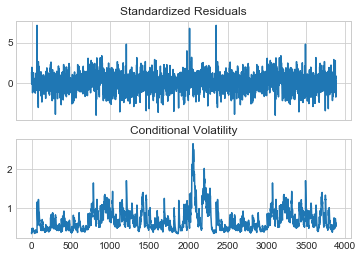

In [67]:
garch_fit.plot()
plt.show()
# plt.savefig("C:\\Users\\ehsan\\Desktop\\qqplot.svg")

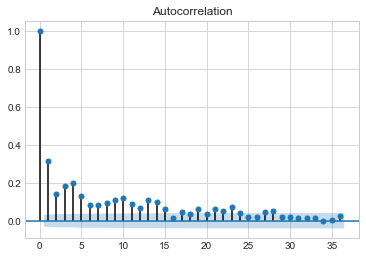

In [68]:
plot_acf(window)
plt.show()
# plt.savefig("C:\\Users\\ehsan\\Desktop\\acf.svg")

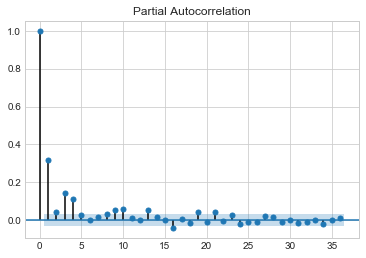

In [69]:
plot_pacf(window)
plt.savefig("C:\\Users\\ehsan\\Desktop\\pacf.svg")

In [43]:
# t0 = time.time()
# forecast_mean = np.zeros_like(test_set2)
# forecast_std = np.zeros_like(test_set2)
# for j in range(0, test_set2.shape[0]):
#     print(j)
#     window = fit_set.values[j:j + window_length]
#     mean = np.mean(window)
#     std = np.std(window)
#     # ARIMA:
#     arima = ARIMA(window, order=(3,0,1))
#     arima_fit = arima.fit(disp=0)
#     arima_output = arima_fit.forecast()
#     forecast_mean[j] = arima_output[0]
#     # GARCH:
#     garch = arch_model(window, mean='AR', dist='normal', vol='garch', p=1, q=1, o=0)
#     garch_fit = garch.fit(disp="off")
#     garch_output = garch_fit.forecast(horizon=1)
#     forecast_std[j] = garch_output.variance.iloc[-1,0]
# print(forecast_mean.shape)
# print(forecast_std.shape)
# t1 = time.time()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [48]:
# tm = t1 - t0
# str(timedelta(seconds=tm))

'0:17:38.613661'

In [94]:
# pd.DataFrame(forecast_mean).to_csv("C:\\Users\\ehsan\\Desktop\\arima and garch\\forecast_mean_arima_iran.csv", index=False)
# pd.DataFrame(forecast_std).to_csv("C:\\Users\\ehsan\\Desktop\\arima and garch\\forecast_std_gjr_garch_t_iran.csv", index=False)

In [25]:
forecast_mean = pd.read_csv("C:\\Users\\ehsan\\Documents\\Khatam\\Thesis\\arima and garch\\forecast_mean_arima_iran.csv", header=0)
forecast_std = pd.read_csv("C:\\Users\\ehsan\\Documents\\Khatam\\Thesis\\arima and garch\\forecast_std_garch_t_iran.csv", header=0)
forecast_mean = forecast_mean.values
forecast_std = forecast_std.values
print(forecast_mean.shape)
print(forecast_std.shape)

(685, 1)
(685, 1)


<a id='section14'></a>
## 5.2 Encoding the Shape of uncertainty

As discussed earlier, the variational auto-encoder is here to give us the shape of uncertainty for our portfolio's returns. Technically, this means that from the model, we get a forecasted distribution for the portfolio's returns without any scale. This is where neural networks' released assumptions work for us and we don't have to implement pre-definitive distributions like Normal distribution for the returns.

In [26]:
test_latent = encoder.predict(test_set)
z_mean = test_latent[0]
z_std = np.exp(0.5 * test_latent[1])
print(z_mean.shape)
print(z_std.shape)

(685, 5)
(685, 5)


In [27]:
n = z_mean.shape[0]
m = 100 # for each one generated
gen_latent = np.zeros((n * m, latent_dim))
for j in range(n):
    mean = z_mean[j, :].reshape((1, latent_dim))
    std = z_std[j, :].reshape((1, latent_dim))
    z_standard = np.random.normal(0, 1, size=(m, 1))
    gen_latent[j * m: (j + 1) * m, :] = np.dot(z_standard, std) + np.repeat(mean, m, axis=0)

In [28]:
gen_latent.shape

(68500, 5)

In [29]:
# %%timeit
generated = decoder.predict(gen_latent)
generated = (generated * (Max.values - Min.values)) + Min.values
generated.shape

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [30]:
i=10
print(cols[i])

ثنوسا


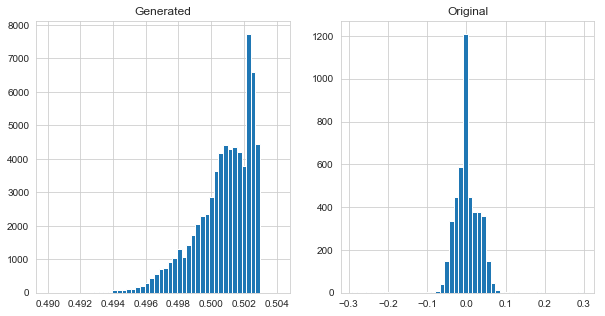

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(generated[:,i], bins=50) # histogram of generated values:
ax1.set_title("Generated")
ax2.hist(rets.iloc[:,i], bins=50) # histogram of real values:
ax2.set_title("Original")
plt.show()
# plt.savefig("C:\\Users\\ehsan\\Desktop\\kernel.svg")

<a id='section15'></a>
## 5.3 Imposing the Mean and the STD

Using the samples generated by the network, after imposing the mean and the std that is brought by ARIMA and GARCH,we are able to calculate VaR and CVaR using quantiles.


In [32]:
port_rets = np.dot(generated, weights)
std = np.std(port_rets)
mean = np.mean(port_rets)
VaRs = np.zeros_like(test_set2)
for j in range(forecast_mean.shape[0]):
    STD = np.sqrt(forecast_std[j]) / 100.0
    MEAN = forecast_mean[j] / 100.0
    beta = STD / std
    port_rets_scaled = MEAN + (port_rets - mean) * beta
    encoded_VaR = np.percentile(port_rets_scaled, alpha)
    VaRs[j] = encoded_VaR
print(VaRs.shape)

(685, 1)


<a id='section16'></a>
# 6.Calculating VaR of Benchmark Models

In order to be able to evaluate the performance of our proposed method, there should be other models for estimating VaR and CVaR of the same portfolio. This wil help us have benchmark performance to compare with the model's.

<a id='section24'></a>
## 6.1 Historical Simulation

In this method, historical distribution is considered to be the distribution of the portfolio's returns in the future. see [Historical Simulation](https://www.value-at-risk.net/motivation-historical-simulation/)

In [33]:
# historical simulation
window_length = train_set2.shape[0] + valid_set2.shape[0]
fit_set = rets.dot(weights)
hist_VaR = np.zeros_like(test_set2)
for j in range(test_set2.shape[0]):
    window = fit_set.values[j:j + window_length]
    var = np.percentile(window, alpha)
    hist_VaR[j] = var
print(hist_VaR.shape)

(685, 1)


<a id='section38'></a>
## 6.2 Monte Carlo Simulation

Monte Carlo simulation in estimating value-at-risk, requires a pre-definite distribution like normal distribution. Then, using multiple times of sampling from that distribution, we get a group of samples based upon that distribution. The alpha percentage of the most negative values from the group of samples is going to be the estimated VaR using this method.

In [34]:
n_samples = 10000
STD = np.sqrt(forecast_std) / 100.0
MEAN = forecast_mean / 100.0
raw_samples = np.random.normal(0,1, size=(1, n_samples))
samples_with_scale = np.repeat(MEAN, n_samples, axis=1) + np.dot(STD, raw_samples)
mc_VaR = np.percentile(samples_with_scale, q=alpha, axis=1)
print(mc_VaR.shape)

(685,)


<a id='section17'></a>
# 7.Backtesting the Resulted Values

By now, we calculated VaR using VAE method and the alternative models. Now we should backtest the resulting VaR series with Christoffersson's method and Lopez' loss function. Then we can compare the performance of the models in forecasting the VaR of our portfolio.

In [35]:
models = ['Variational AE','Historical Simulation','Monte Carlo']
columns = [('Unconditional', 'Statistic'),('Unconditional', 'p-Value'),('Independence', 'Statistic'),('Independence', 'p-Value'),('Conditional', 'Statistic'),('Conditional', 'p-Value')]
Christoffersson = pd.DataFrame(index = models, columns = pd.MultiIndex.from_tuples(columns))
Lopez = pd.DataFrame(index = models, columns = ['Mean Loss'])
Christoffersson.head()
# Lopez.head()

Unconditional         Independence         Conditional  \
                          Statistic p-Value    Statistic p-Value   Statistic   
Variational AE                  NaN     NaN          NaN     NaN         NaN   
Historical Simulation           NaN     NaN          NaN     NaN         NaN   
Monte Carlo                     NaN     NaN          NaN     NaN         NaN   

                               
                      p-Value  
Variational AE            NaN  
Historical Simulation     NaN  
Monte Carlo               NaN

<a id='section18'></a>
## 7.1 Backtesting Encoded VaR

In [36]:
encoded_VaRs = pd.DataFrame(VaRs, index=test_idx)
real_returns = pd.DataFrame(test_set2, index=test_idx)
bt_var = Backtest(actual=real_returns.iloc[:,0], forecast=encoded_VaRs.iloc[:,0], alpha=alpha/100.0)

In [37]:
encoded_VaRs.describe()

,0
count,685.000000
mean,-0.014159
std,0.009075
min,-0.066205
25%,-0.017419
50%,-0.011840
75%,-0.008114
max,-0.004039


In [40]:
mc_VaRs.describe()

NameError: name 'mc_VaRs' is not defined

In [41]:
print("Number of VaR Violations: %r times"% bt_var.number_of_hits())
print("Percentage of VaR Violations: %1.4f percents"% (bt_var.hit_rate() * 100.0))

Number of VaR Violations: 20 times
Percentage of VaR Violations: 2.9197 percents


<a id='section19'></a>
### 7.1.1 Actual Returns vs Forecasted VaR Plot

In the plot below, we see green dots which are the positive returns in the forecast horizon though yellow dots are the negative ones. The black line is the forecasted VaR and the red dots are the VaR violations.

In [43]:
# bt_var.plot(file_name="C:\\Users\\ehsan\\Desktop\\results\\bt-var-garch-t.svg")

<a id='section20'></a>
### 7.1.2 Statistical Tests of Christoffersson's Method

* Unconditional coverage null hypothesis: percentage of violation equals P
* Independence null hypothesis: if violations are independent
* Conditional: null of unconditional and alternative of independence

In [44]:
df = bt_var.lr_bt()
Christoffersson.iloc[0, :] = df.values.flatten()
df

,Statistic,p-value
Unconditional,7.248340,0.007097
Independence,2.302775,0.129143
Conditional,9.551115,0.008433


<a id='section50'></a>
## 7.1.3 Lopez Loss Function

Lopez (1999) had suggested using an alternative method of backtesting which instead of a statistical test, evaluates a loss function to compare different methods.

In [316]:
vio_series = bt_var.duration_series()
loss = 1 + (test_set2[vio_series] - VaRs[vio_series]) ** 2
Lopez.loc['Variational AE','Mean Loss'] = np.mean(loss)
print(np.mean(loss))

1.000123982138876


In [317]:
vio_series

array([ 4, 13, 43, 20, 59, 22, 55,  3, 56,  2,  1, 37, 24,  1,  3, 10, 38,
       10, 59, 36,  3, 36,  1,  8, 58, 46,  1, 32,  3], dtype=int64)

<a id='section25'></a>
## 7.2 Backtesting Historical Simulation VaR

In [45]:
hs_VaRs = pd.DataFrame(hist_VaR, index=test_idx)
real_returns = pd.DataFrame(test_set2, index=test_idx)
bt_var = Backtest(actual=real_returns.iloc[:,0], forecast=hs_VaRs.iloc[:,0], alpha=alpha/100.0)

In [46]:
print("Number of VaR Violations: %r times"% bt_var.number_of_hits())
print("Percentage of VaR Violations: %1.4f percents"% (bt_var.hit_rate() * 100.0))

Number of VaR Violations: 42 times
Percentage of VaR Violations: 6.1314 percents


<a id='section26'></a>
### 7.2.1 Actual Returns vs Forecasted VaR Plot

In the plot below, we see green dots which are the positive returns in the forecast horizon though yellow dots are the negative ones. The black line is the forecasted VaR and the red dots are the VaR violations.

In [47]:
# bt_var.plot(file_name="C:\\Users\\ehsan\\Desktop\\results\\bt-hs-garch-t.svg")

<a id='section27'></a>
### 7.2.2 Statistical Tests of Christoffersson's Method

* Unconditional coverage null hypothesis: percentage of violation equals P
* Independence null hypothesis: if violations are independent
* Conditional: null of unconditional and alternative of independence

In [48]:
df = bt_var.lr_bt()
Christoffersson.iloc[1, :] = df.values.flatten()
df

,Statistic,p-value
Unconditional,1.751300,1.857134e-01
Independence,37.042449,1.155854e-09
Conditional,38.793748,3.767425e-09


<a id='section70'></a>
## 7.2.3 Lopez Loss Function

Lopez (1999) had suggested using an alternative method of backtesting which instead of a statistical test, evaluates a loss function to compare different methods.

In [49]:
vio_series = bt_var.duration_series()
loss = 1 + (test_set2[vio_series] - hist_VaR[vio_series]) ** 2
Lopez.loc['Historical Simulation','Mean Loss'] = np.mean(loss)
print(np.mean(loss))

1.000184301472246


In [50]:
vio_series

array([ 4, 13, 43, 79,  7, 70,  3,  1, 57,  1, 62,  3, 10,  8, 30,  1,  9,
       59,  1,  1,  1,  1,  2,  1,  7,  1,  1,  1,  4,  9,  1,  5,  2,  1,
       37, 56, 10,  1, 28, 17,  1, 32,  3], dtype=int64)

<a id='section39'></a>
## 7.3 Backtesting Monte Carlo Simulation VaR

In [51]:
mc_VaRs = pd.DataFrame(mc_VaR, index=test_idx)
real_returns = pd.DataFrame(test_set2, index=test_idx)
bt_var = Backtest(actual=real_returns.iloc[:,0], forecast=mc_VaRs.iloc[:,0], alpha=alpha/100.0)

In [52]:
print("Number of VaR Violations: %r times"% bt_var.number_of_hits())
print("Percentage of VaR Violations: %1.4f percents"% (bt_var.hit_rate() * 100.0))

Number of VaR Violations: 29 times
Percentage of VaR Violations: 4.2336 percents


<a id='section40'></a>
### 7.3.1 Actual Returns vs Forecasted VaR Plot

In the plot below, we see green dots which are the positive returns in the forecast horizon though yellow dots are the negative ones. The black line is the forecasted VaR and the red dots are the VaR violations.

In [53]:
# bt_var.plot(file_name="C:\\Users\\ehsan\\Desktop\\results\\bt-mc-garch-t.svg")

<a id='section41'></a>
### 7.3.2 Statistical Tests of Christoffersson's Method

* Unconditional coverage null hypothesis: percentage of violation equals P
* Independence null hypothesis: if violations are independent
* Conditional: null of unconditional and alternative of independence

In [54]:
df = bt_var.lr_bt()
Christoffersson.iloc[2, :] = df.values.flatten()
df

,Statistic,p-value
Unconditional,0.875573,0.349417
Independence,4.655202,0.030960
Conditional,5.530775,0.062952


<a id='section60'></a>
## 7.3.3 Lopez Loss Function

Lopez (1999) had suggested using an alternative method of backtesting which instead of a statistical test, evaluates a loss function to compare different methods.

In [55]:
vio_series = bt_var.duration_series()
loss = 1 + (test_set2[vio_series] - mc_VaR[vio_series]) ** 2
Lopez.loc['Monte Carlo','Mean Loss'] = np.mean(loss)
print(np.mean(loss))

1.0001154496556004


In [56]:
vio_series

array([ 4, 13, 43, 20, 59, 22, 55,  3, 56,  2,  1, 37, 24,  1,  3, 10, 38,
       10, 59, 36,  3, 36,  1,  8, 58, 46,  1, 32,  3], dtype=int64)

<a id='section45'></a>
# 8.Sum Up

Now, we calculated and backtested all the risk measures and the models. Here, we compare Christoffersson's tests for each one of them and we check the Lopez loss functions to see which one has produced least loss.

Note: When p-value is under the defined error, the number turns red. (It means accepted)

In [57]:

def inverse_color_significance(val):
    color = 'red' if val > error else 'black'
    return 'color: %s' % color

def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]

In [58]:
print('Christoffersson Tests:')
Christoffersson.style.applymap(inverse_color_significance, subset=[x for x in columns if x[1]=='p-Value'])

Christoffersson Tests:


In [59]:
print('Lopez Loss:')
Lopez.sort_values(by='Mean Loss', ascending=True).style.apply(highlight_min)

Lopez Loss:


,Mean Loss
Monte Carlo,1.00012
Historical Simulation,1.00018
Variational AE,nan
